In [24]:
# import packages and read in full dataset (pca features)
from read_data import get_all_data, split_and_stratify_data, get_balanced_df


import warnings
warnings.filterwarnings('ignore') # for looks..

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, log_loss, matthews_corrcoef
import scikitplot as skplt

full_dataset = get_all_data(number_of_pca_features = 100)
full_dataset.head()

GroundTruth.csv read. Processing/searching for image data. May take a few minutes if process_images_again == True.

Existing image data read..
Here is the cumulative variance explained by the top n principal components..
[0.31257716 0.54008686 0.66481299 0.7057795  0.74346465 0.77956174
 0.80114615 0.81924822 0.83539777 0.8507423  0.86424108 0.8750329
 0.88251965 0.88884104 0.89510091 0.90050337 0.90577069 0.91083161
 0.91540637 0.91968503 0.92259132 0.92535737 0.92803304 0.93063927
 0.93311294 0.93549835 0.93778653 0.93980628 0.94179666 0.94344428
 0.94486636 0.94619368 0.94750187 0.94877141 0.95000678 0.95122232
 0.95237959 0.9534572  0.95452557 0.95557189 0.95661161 0.95758342
 0.95852778 0.95936875 0.96019455 0.96099447 0.96176479 0.96252313
 0.96324924 0.9639561  0.96464723 0.96529059 0.96592324 0.9665458
 0.96711326 0.96765529 0.96819545 0.96870674 0.96921178 0.96970669
 0.97018163 0.97064448 0.97110586 0.97154421 0.971972   0.97238688
 0.97279964 0.97319277 0.97357719 0.97395033

,image,cancer_type,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,ISIC_0024306.jpg,NV,2.227468,-3.264277,-1.167765,0.924474,-2.286435,1.804567,0.273134,0.418798,...,-0.099027,-0.009333,-0.051041,-0.019836,-0.134981,0.083766,0.020061,-0.062348,-0.155223,-0.037895
1,ISIC_0024307.jpg,NV,1.068419,-1.742836,-2.110399,0.040784,-1.148290,0.792414,0.011848,0.533355,...,-0.039695,-0.032529,0.015959,-0.021628,-0.059418,-0.019899,0.006778,0.107662,-0.039652,-0.009560
2,ISIC_0024308.jpg,NV,0.983078,-4.920764,0.617789,1.684504,-0.617451,-0.853629,-0.934357,0.139916,...,0.103498,0.018952,0.015636,0.057682,0.015973,0.040700,0.187303,-0.050769,0.090087,0.106535
3,ISIC_0024309.jpg,NV,4.042187,-1.004445,-1.730627,0.354093,0.451159,-2.407673,0.339228,-0.318631,...,-0.080027,-0.027284,0.011457,0.087806,-0.070773,-0.000180,-0.049357,0.022274,0.046849,-0.057677
4,ISIC_0024310.jpg,MEL,0.925909,-0.801578,-0.337978,1.529686,-0.320369,0.183890,-0.863793,0.924670,...,0.221153,0.113545,0.000518,0.071552,0.341293,-0.269370,0.305026,-0.021116,0.292971,0.065647


In [25]:
# split into train test and validation datasets
train, test, validate = split_and_stratify_data(full_dataset, random = 1)

# balance the training set?
#train = get_balanced_df(train, val_size = 1000, col = 'cancer_type')

# create X and y train, test and validate sets
X_train = train.iloc[:,2:-1]
X_test = test.iloc[:,2:-1]
X_validate = validate.iloc[:,2:-1]

y_train = train.iloc[:,1]
y_test = test.iloc[:,1]
y_validate = validate.iloc[:,1]

print('Training Set Cancer Counts')
print(y_train.value_counts())
print('Test Set Cancer Counts')
print(y_test.value_counts())
print('Validation Set Cancer Counts')
print(y_validate.value_counts())

Training Set Cancer Counts
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: cancer_type, dtype: int64
Test Set Cancer Counts
NV       670
MEL      111
BKL      110
BCC       51
AKIEC     33
VASC      14
DF        12
Name: cancer_type, dtype: int64
Validation Set Cancer Counts
NV       671
MEL      112
BKL      110
BCC       52
AKIEC     32
VASC      14
DF        11
Name: cancer_type, dtype: int64


In [28]:
# function for evaluating a classification model

def evaluate_model(model, y_test, X_test):

    y_pred = model.predict(X_test)
    y_probas = model.predict_proba(X_test)

    print(f'Model Accuracy is {round(accuracy_score(y_test, y_pred),4)*100}%')
    print(f'Log loss of the model is {round(log_loss(y_test, y_probas), 3)}')
    print(f'Matthews Correlation Coefficient is {round(matthews_corrcoef(y_test, y_pred),3)}')
    print('\nHere is the classification report. \n')
    print(classification_report(y_test, y_pred))

    print('Confusion Matrix is here:\n')
    plot_confusion_matrix(model, X_test, y_test)  
    plt.show() 

    print('Here are the ROC Curves: \n')
    skplt.metrics.plot_roc_curve(y_test, y_probas)
    plt.show()
    

# Random Forest Classifier

Model Accuracy is 68.96%
Log loss of the model is 0.836
Matthews Correlation Coefficient is 0.215

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        32
         BCC       1.00      0.08      0.14        52
         BKL       0.56      0.09      0.16       110
          DF       0.00      0.00      0.00        11
         MEL       0.43      0.12      0.18       112
          NV       0.70      0.99      0.82       671
        VASC       0.00      0.00      0.00        14

    accuracy                           0.69      1002
   macro avg       0.38      0.18      0.19      1002
weighted avg       0.63      0.69      0.59      1002

Confusion Matrix is here:



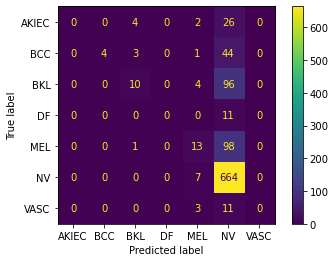

Here are the ROC Curves: 



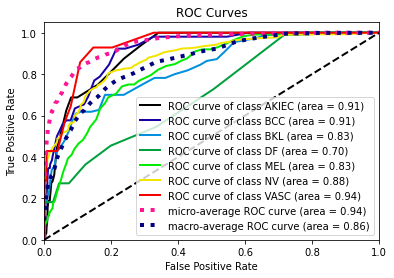

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=150, random_state=42)
forest_clf.fit(X_train, y_train)

evaluate_model(model = forest_clf, y_test = y_validate, X_test = X_validate)

Not great.. Overpredicting NV - try hyperparameter tuning..

#  Gaussian Naive Bayes

Model Accuracy is 61.980000000000004%
Log loss of the model is 4.325
Matthews Correlation Coefficient is 0.265

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.41      0.28      0.33        32
         BCC       0.29      0.13      0.18        52
         BKL       0.19      0.10      0.13       110
          DF       0.19      0.27      0.22        11
         MEL       0.27      0.47      0.35       112
          NV       0.79      0.80      0.79       671
        VASC       0.40      0.29      0.33        14

    accuracy                           0.62      1002
   macro avg       0.36      0.33      0.33      1002
weighted avg       0.61      0.62      0.61      1002

Confusion Matrix is here:



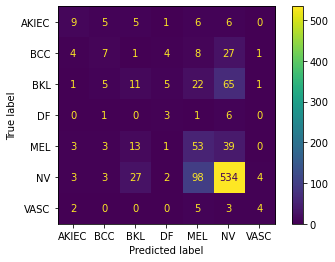

Here are the ROC Curves: 



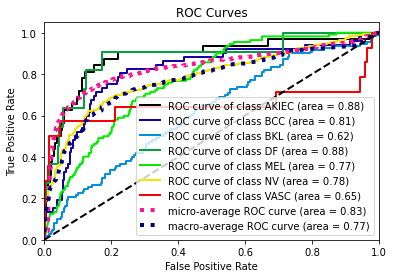

In [33]:
from sklearn.naive_bayes import GaussianNB

gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, y_train)

evaluate_model(model = gaussian_clf, y_test = y_validate, X_test = X_validate)

Not so good compared to other models. Try hyperparameter tuning..

# Logistic Regression

Model Accuracy is 69.76%
Log loss of the model is 0.833
Matthews Correlation Coefficient is 0.322

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.43      0.09      0.15        32
         BCC       0.49      0.40      0.44        52
         BKL       0.53      0.34      0.41       110
          DF       0.00      0.00      0.00        11
         MEL       0.34      0.13      0.19       112
          NV       0.75      0.92      0.83       671
        VASC       0.44      0.29      0.35        14

    accuracy                           0.70      1002
   macro avg       0.43      0.31      0.34      1002
weighted avg       0.64      0.70      0.65      1002

Confusion Matrix is here:



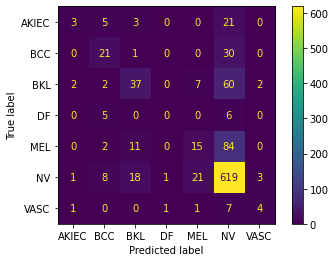

Here are the ROC Curves: 



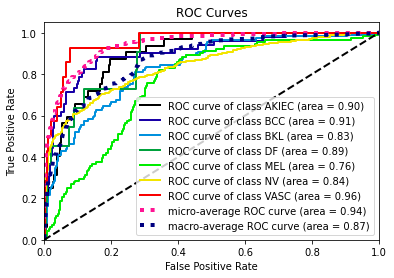

In [34]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=42)
logreg_clf.fit(X_train, y_train)

evaluate_model(model = logreg_clf, y_test = y_validate, X_test = X_validate)

Not bad - fairly quick. ROC curve for MEL not great. Try Hyperparameter tuning.

# k-Nearest Neighbors

Model Accuracy is 69.96%
Log loss of the model is 4.812
Matthews Correlation Coefficient is 0.358

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.30      0.19      0.23        32
         BCC       0.43      0.38      0.40        52
         BKL       0.40      0.41      0.40       110
          DF       0.00      0.00      0.00        11
         MEL       0.30      0.10      0.15       112
          NV       0.79      0.92      0.85       671
        VASC       0.50      0.07      0.12        14

    accuracy                           0.70      1002
   macro avg       0.39      0.30      0.31      1002
weighted avg       0.65      0.70      0.66      1002

Confusion Matrix is here:



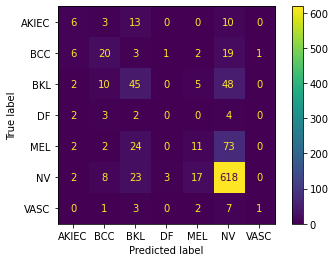

Here are the ROC Curves: 



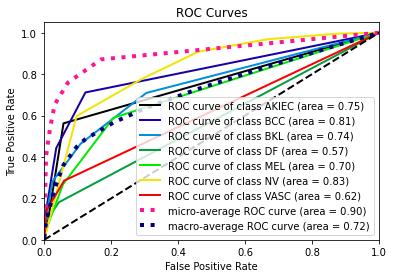

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

evaluate_model(model = knn_clf, y_test = y_validate, X_test = X_validate)

Not looking so good.. AUC Curves and log loss are bad compared to other models.

# Kernel Support Vector Machines

Model Accuracy is 72.65%
Log loss of the model is 0.728
Matthews Correlation Coefficient is 0.379

Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.33      0.16      0.21        32
         BCC       0.50      0.37      0.42        52
         BKL       0.56      0.34      0.42       110
          DF       0.00      0.00      0.00        11
         MEL       0.53      0.07      0.13       112
          NV       0.76      0.98      0.86       671
        VASC       0.00      0.00      0.00        14

    accuracy                           0.73      1002
   macro avg       0.38      0.27      0.29      1002
weighted avg       0.67      0.73      0.66      1002

Confusion Matrix is here:



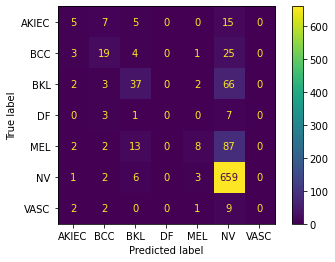

Here are the ROC Curves: 



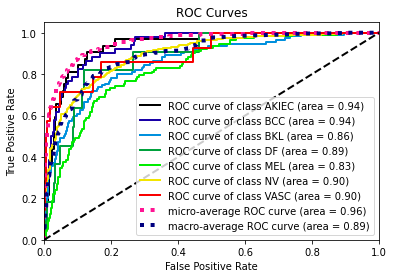

In [38]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', probability = True, random_state=42)
svm_clf.fit(X_train, y_train)

evaluate_model(model = svm_clf, y_test = y_validate, X_test = X_validate)

Seems to be the best performing model out of all of these so far..